# Mask Model

## Dependencies

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

# Import the dependencies.
# OpenCV
import cv2

# TensorFlow and tf.keras
# https://www.tensorflow.org/api_docs/python/tf/keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, save_model, load_model

# Helper libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow Libraries Matter for Speed!!!
print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15610286538566090712
]


## Data Loading

In [2]:
# Processed folder houses the already seperated image files
# Images are separated into two categories "without_mask" & "with_mask"
# Grab the location of the processed folder
train_data_path = "../data/processed/train"

# grab the two folder groups and make them to categories
categories = os.listdir(train_data_path)
labels = [i for i in range(len(categories))]

# Initialize an empty dictionary for labels
label_dict = dict(zip(categories, labels))

print(f"Printing the labels'dict' {label_dict}")
print(f"Printing the categories'list' {categories}")
print(f"Printing the labels as digits {labels}")


Printing the labels'dict' {'without_mask': 0, 'with_mask': 1}
Printing the categories'list' ['without_mask', 'with_mask']
Printing the labels as digits [0, 1]


In [3]:
# Processed folder houses the already seperated image files
# Images are sperated into two categories "without_mask" & "with_mask"
# Grab the location of the processed folder
test_data_path = "../data/processed/test"

# grab the two folder groups and make them to categories
test_categories = os.listdir(test_data_path)
test_labels = [i for i in range(len(test_categories))]

# Initialize an empty dictionary for labels
test_label_dict = dict(zip(test_categories, test_labels))

print(f"Printing the labels'dict' {test_label_dict}")
print(f"Printing the categories'list' {test_categories}")
print(f"Printing the labels as digits {test_labels}")


Printing the labels'dict' {'without_mask': 0, 'with_mask': 1}
Printing the categories'list' ['without_mask', 'with_mask']
Printing the labels as digits [0, 1]


## Data Preprocessing

In [4]:
# Normalizing all images to the same size 300x300
img_size = 100
# List
data = []
target = []

# Looping through the processed folder grabing each image
# processing that image through cv2 to gray scale and demension
for category in categories:
    folder_path = os.path.join(train_data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        try:
            # Coverting the image into gray scale
            gray = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
            # Resizing the gray scale into 100x100, since we need a fixed common size for all the images in the dataset
            resized = cv2.resize(gray, (img_size, img_size))
            # Appending the image and the label(categorized) into the list (dataset)
            data.append(resized)
            target.append(label_dict[category])

        except Exception as e:
            # If any exception raised, the exception will be printed here. And pass to the next image
            print("Exception:", e)


In [17]:
# Create a numpy array to store data and target
# Normalize data
data = np.array(data) / 255.0

data = np.reshape(data, (data.shape[0], img_size, img_size, 1))
target = np.array(target)

# Use the keras utils tool to create categorical target
new_target = tf.keras.utils.to_categorical(target)

(4463, 100, 100, 1)


In [6]:
# https://numpy.org/doc/stable/reference/generated/numpy.save.html
np.save("numpy/data", data)
np.save("numpy/target", new_target)


## Building a Model

Using a convolutional neural network (CNN) class of deep learning model.

In [7]:
# Loading in the saved numpy arrays in the previous code
data = np.load("numpy/data.npy")
target = np.load("numpy/target.npy")
print(data.shape[1:])

(100, 100, 1)


In [8]:
# Create the model
model = Sequential()

# The first CNN layer followed by Relu and MaxPooling layers
model.add(layers.Conv2D(50, (3, 3), activation="relu", input_shape=(100, 100, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# The second convolution layer followed by Relu and MaxPooling layers
model.add(layers.Conv2D(50, (1, 1), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# The thrid convolution layer followed by Relu and MaxPooling layers
model.add(layers.Conv2D(100, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# The fourth convolution layer followed by Relu and MaxPooling layers
model.add(layers.Conv2D(200, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten layer to stack the output convolutions from the fourth convolution layer
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

# Dense layer of X neurons
model.add(layers.Dense(50, activation="relu"))
# The Final layer with two outputs for two categories
model.add(layers.Dense(2, activation="softmax"))

print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 50)        500       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 49, 49, 50)        2550      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 100)       45100     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 100)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 200)         1

In [9]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


## Train the Model

In [10]:
from sklearn.model_selection import train_test_split

# Use the train_test_split to split the data into training and testing set.
# The data set isnt very large so only using 10% to test.
train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.1
)


In [11]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model_checkpoints/model-{epoch:03d}.model",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    mode="auto",
)
history = model.fit(
    train_data, train_target, epochs=30, callbacks=[checkpoint], validation_split=0.2
)


Epoch 1/30
101/101 [==============================] - 15s 139ms/step - loss: 0.6477 - accuracy: 0.5956 - val_loss: 0.4184 - val_accuracy: 0.8358
INFO:tensorflow:Assets written to: model_checkpoints\model-001.model\assets
Epoch 2/30
101/101 [==============================] - 14s 142ms/step - loss: 0.4280 - accuracy: 0.8101 - val_loss: 0.2753 - val_accuracy: 0.8905
INFO:tensorflow:Assets written to: model_checkpoints\model-002.model\assets
Epoch 3/30
101/101 [==============================] - 14s 143ms/step - loss: 0.2599 - accuracy: 0.8959 - val_loss: 0.2312 - val_accuracy: 0.9241
INFO:tensorflow:Assets written to: model_checkpoints\model-003.model\assets
Epoch 4/30
101/101 [==============================] - 16s 155ms/step - loss: 0.2300 - accuracy: 0.8981 - val_loss: 0.1978 - val_accuracy: 0.9279
INFO:tensorflow:Assets written to: model_checkpoints\model-004.model\assets
Epoch 5/30
101/101 [==============================] - 16s 161ms/step - loss: 0.1670 - accuracy: 0.9392 - val_loss: 0

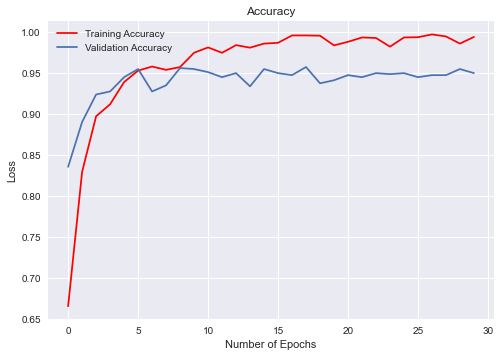

In [12]:
# Another Chart of what
# Defined style for plot
plt.style.use("seaborn")
plt.title("Accuracy")
plt.plot(history.history["accuracy"], "r", label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("../resources/accuracy.png")
plt.show()


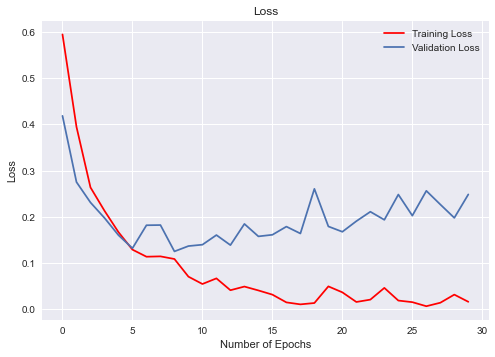

In [13]:
# Chart of What?
# Defined style for plot
plt.style.use("seaborn")
plt.title("Loss")
plt.plot(history.history["loss"], "r", label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("../resources/loss.png")
plt.show()


Double check of over fitting... Usually, when a model performs great on training data but poorly on validation data, we call this condition overfitting... we need more solid data or use Keras Data augmentation 

In [14]:
print(model.evaluate(test_data, test_target))


14/14 [==============================] - 1s 38ms/step - loss: 0.3876 - accuracy: 0.9284
[0.3875574469566345, 0.9284116625785828]


In [15]:
# Properly save the model for API use.
model.save("./model_checkpoints/model")


INFO:tensorflow:Assets written to: ./model_checkpoints/model\assets
